In [ ]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from scipy.stats import randint

from skorch import NeuralNetBinaryClassifier

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [ ]:
#define a function that split target column from dataset.
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input = 6, hidden_units = 100):
        super(BinaryClassification, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_input, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )
        
    def forward(self, inputs, **kwargs):
        x = self.layers(inputs)

        return x

In [ ]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [ ]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
427,1,3,3,2,3,2,2
428,1,3,3,2,3,3,1
429,1,3,3,2,3,3,2
430,1,3,3,2,3,4,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

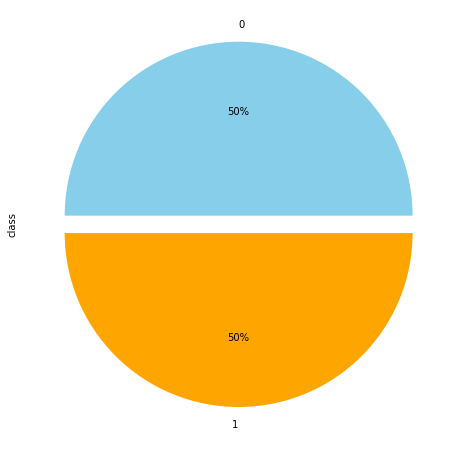

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

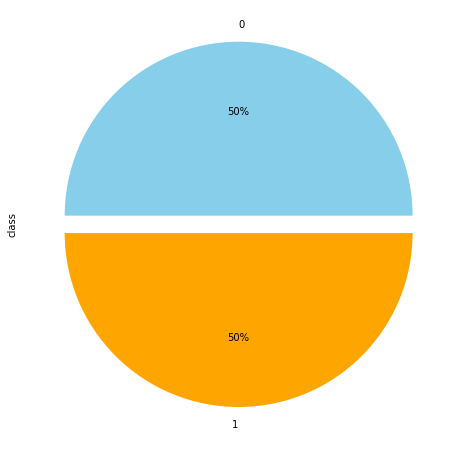

In [ ]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

### Using skorch and sklearn
In this part, use skorch and sklearn to define a good model with MONKs

In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score_monk(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    train_loss_mse = []
    test_loss_mse = []

    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train, classes = np.unique(y_train))
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_loss.append(log_loss(y_train, y_train_predicted))
        train_loss_mse.append(mean_squared_error(y_train, y_train_predicted))
        train_scores.append(accuracy_score(y_train, y_train_predicted))
        #result on test set
        test_loss.append(log_loss(y_test, y_test_predicted))
        test_loss_mse.append(mean_squared_error(y_test, y_test_predicted))
        test_scores.append(accuracy_score(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss, train_loss_mse, test_loss_mse

### One hot encoding in MONK-1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

(124, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit_enc = X_train_M1.astype(np.single)
y_trainFit_enc = y_train_M1.astype(np.single)

X_testFit_enc = X_test_M1.astype(np.single)
y_testFit_enc = y_test_M1.astype(np.single)

In [ ]:
net_enc = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit_enc.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size=4,
    lr = 0.05,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.001,
    #optimizer__momentum=0.85,
    #optimizer__nesterov=True,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)
train_scores_M1, test_scores_M1, train_loss_M1, test_loss_M1, train_loss_M1_mse, test_loss_M1_mse = fit_and_score_monk(150, net_enc, X_trainFit_enc, y_trainFit_enc, X_testFit_enc, y_testFit_enc)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6935  0.0225
      2        0.6882  0.0202
      3        0.6821  0.0204
      4        0.6743  0.0203
      5        0.6647  0.0207
      6        0.6520  0.0206
      7        0.6368  0.0205
      8        0.6199  0.0240
      9        0.6011  0.0244
     10        0.5807  0.0205
     11        0.5576  0.0201
     12        0.5353  0.0205
     13        0.5123  0.0205
     14        0.4911  0.0210
     15        0.4704  0.0235
     16        0.4541  0.0233
     17        0.4397  0.0207
     18        0.4270  0.0205
     19        0.4153  0.0204
     20        0.4051  0.0200
     21        0.3955  0.0204
     22        0.3874  0.0201
     23        0.3792  0.0205
     24        0.3725  0.0235
     25        0.3659  0.0204
     26        0.3598  0.0250
     27        0.3532  0.0208
     28        0.3470  0.0218
     29        0.3419  0.0234
     30        0.3365  0.0306
     31        0.3317  0.0212
     32   

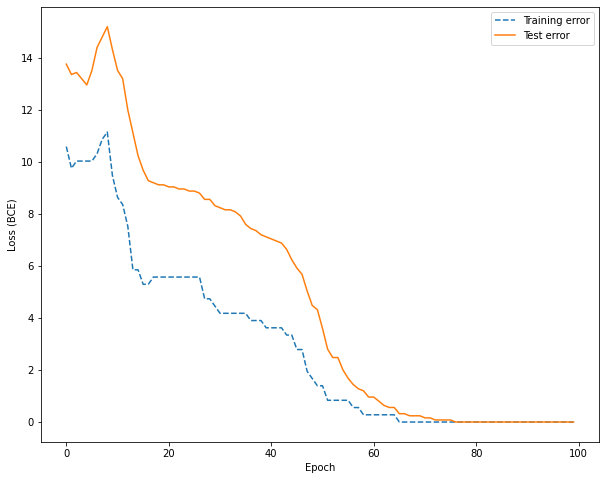

In [ ]:
plot_learning_curves(train_loss_M1, test_loss_M1, 100, 'Loss (BCE)')

In [ ]:
plot_learning_curves(train_loss_M1_mse, test_loss_M1_mse, 150, 'Loss (MSE)')

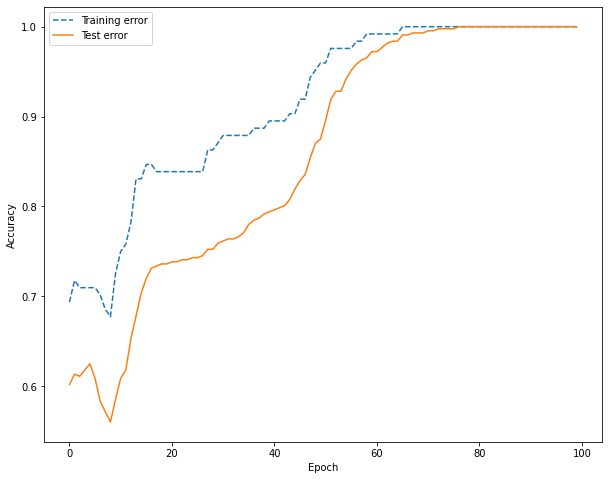

In [ ]:
plot_learning_curves(train_scores_M1, test_scores_M1, 100, 'Accuracy')

In [ ]:
y_predicted_M1 = net_enc.predict(X_testFit_enc)
print(f"Accuracy on MONK1: {net_enc.score(X_testFit_enc, y_testFit_enc)}")
print(f"MEE on MONK1: {(np.linalg.norm(y_predicted_M1-y_testFit_enc))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK1: 1.0
MEE on MONK1: 0.0


In [ ]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit_enc, y_predicted_M1))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       216
         1.0       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

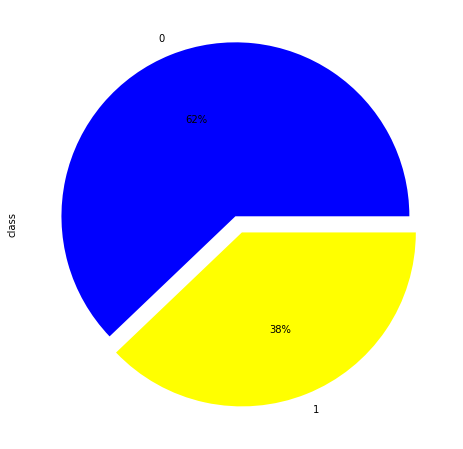

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

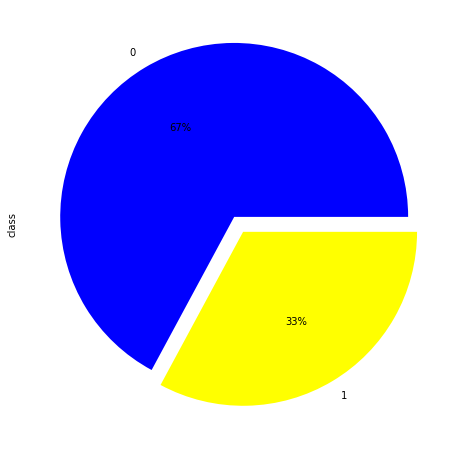

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
X_train_M2, y_train_M2, X_test_M2, y_test_M2 = split_train_test(df_monk2_train, df_monk2_test)

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M2)
X_train_M2 = enc_train.transform(X_train_M2).toarray()
print(X_train_M2.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M2)
X_test_M2 = enc_test.transform(X_test_M2).toarray()
print(X_test_M2.shape)


(169, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit2 = X_train_M2.astype(np.single)
y_trainFit2 = y_train_M2.astype(np.single)

X_testFit2 = X_test_M2.astype(np.single)
y_testFit2 = y_test_M2.astype(np.single)

In [ ]:
net_enc2 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit2.shape[1],
    module__hidden_units=3,
    max_epochs=1,
    batch_size = 8,
    lr = 0.01,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.001,
    optimizer__momentum=0.95,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M2, test_scores_M2, train_loss_M2, test_loss_M2, train_loss_M2_mse, test_loss_M2_mse = fit_and_score_monk(100, net_enc2, X_trainFit2, y_trainFit2, X_testFit2, y_testFit2)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6688  0.0542
      2        0.6633  0.0196
      3        0.6601  0.0177
      4        0.6556  0.0172
      5        0.6493  0.0181
      6        0.6399  0.0183
      7        0.6244  0.0171
      8        0.6006  0.0169
      9        0.5716  0.0172
     10        0.5418  0.0171
     11        0.5011  0.0166
     12        0.4794  0.0188
     13        0.4655  0.0411
     14        0.4129  0.0168
     15        0.3785  0.0168
     16        0.3486  0.0447
     17        0.2894  0.0169
     18        0.2447  0.0170
     19        0.1955  0.0448
     20        0.1608  0.0174
     21        0.1353  0.0216
     22        0.1244  0.0192
     23        0.1109  0.0170
     24        0.0914  0.0170
     25        0.0842  0.0168
     26        0.0716  0.0182
     27        0.0599  0.0169
     28        0.0546  0.0170
     29        0.0482  0.0172
     30        0.0437  0.0167
     31        0.0406  0.0168
     32   

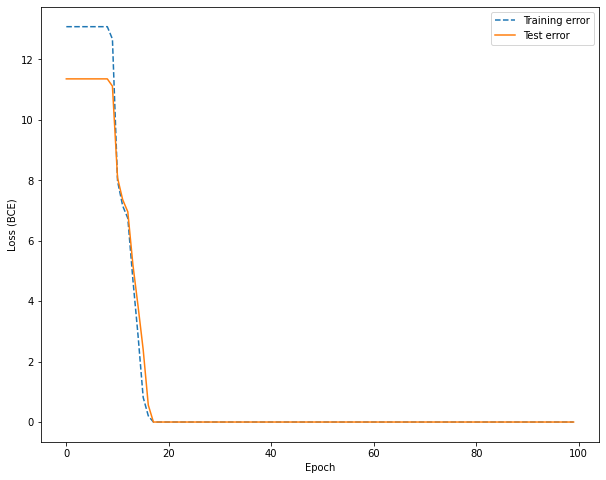

In [ ]:
plot_learning_curves(train_loss_M2, test_loss_M2, 100, 'Loss (BCE)')

In [ ]:
plot_learning_curves(train_loss_M2_mse, test_loss_M2_mse, 100, 'Loss (MSE)')

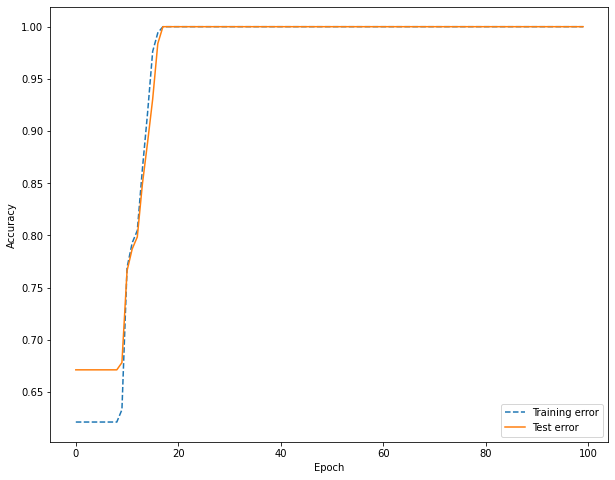

In [ ]:
plot_learning_curves(train_scores_M2, test_scores_M2, 100, 'Accuracy')

In [ ]:
y_predicted_M2 = net_enc2.predict(X_testFit2)
print(f"Accuracy on MONK2: {net_enc2.score(X_testFit2, y_testFit2)}")
print(f"MEE on MONK2: {(np.linalg.norm(y_predicted_M2-y_testFit2))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK2: 1.0
MEE on MONK2: 0.0


In [ ]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit2, y_predicted_M2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       290
         1.0       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



## Loading MONK-3 dataset

In [ ]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

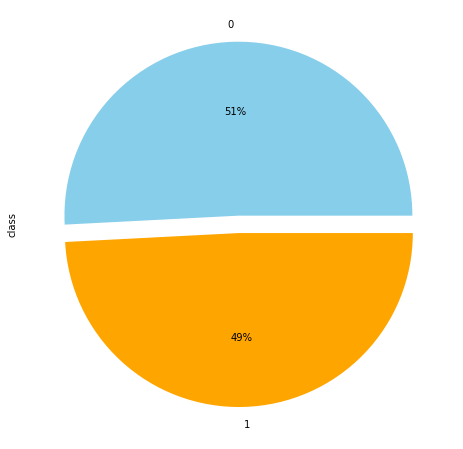

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

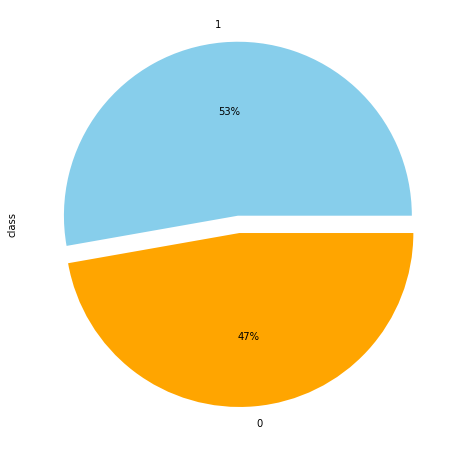

In [ ]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
X_train_M3, y_train_M3, X_test_M3, y_test_M3 = split_train_test(df_monk3_train, df_monk3_test)

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M3)
X_train_M3 = enc_train.transform(X_train_M3).toarray()
print(X_train_M3.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M3)
X_test_M3 = enc_test.transform(X_test_M3).toarray()
print(X_test_M3.shape)

(122, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit3 = X_train_M3.astype(np.single)
y_trainFit3 = y_train_M3.astype(np.single)

X_testFit3 = X_test_M3.astype(np.single)
y_testFit3 = y_test_M3.astype(np.single)

In [ ]:
net_enc3 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit3.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size = 8,
    lr = 0.008,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.0001,
    optimizer__momentum=0.9,
    optimizer__nesterov=True,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M3, test_scores_M3, train_loss_M3, test_loss_M3, train_loss_M3_mse, test_loss_M3_mse = fit_and_score_monk(45, net_enc3, X_trainFit3, y_trainFit3, X_testFit3, y_testFit3)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7082  0.0600
      2        0.7017  0.0127
      3        0.6978  0.0127
      4        0.6952  0.0413
      5        0.6931  0.0128
      6        0.6908  0.0148
      7        0.6882  0.0130
      8        0.6839  0.0128
      9        0.6764  0.0130
     10        0.6646  0.0130
     11        0.6476  0.0127
     12        0.6262  0.0126
     13        0.5994  0.0406
     14        0.5670  0.0135
     15        0.5306  0.0135
     16        0.4937  0.0126
     17        0.4598  0.0143
     18        0.4293  0.0134
     19        0.4030  0.0127
     20        0.3804  0.0408
     21        0.3610  0.0127
     22        0.3453  0.0188
     23        0.3326  0.0407
     24        0.3213  0.0136
     25        0.3133  0.0135
     26        0.3051  0.0129
     27        0.2987  0.0129
     28        0.2928  0.0410
     29        0.2883  0.0129
     30        0.2840  0.0181
     31        0.2801  0.0130
     32   

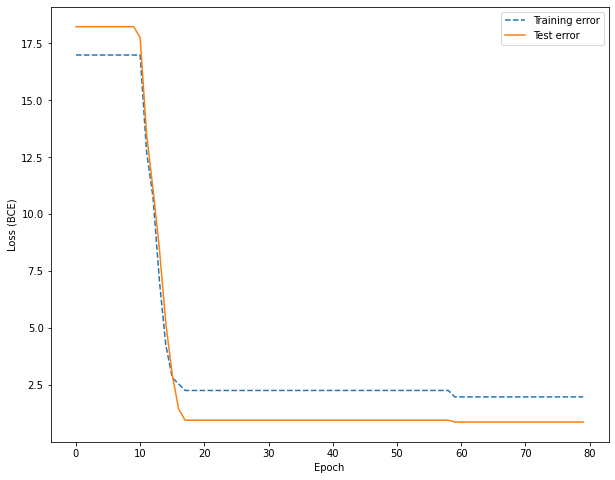

In [ ]:
plot_learning_curves(train_loss_M3, test_loss_M3, 80, 'Loss (BCE)')

In [ ]:
plot_learning_curves(train_loss_M3_mse, test_loss_M3_mse, 45, 'Loss (MSE)')

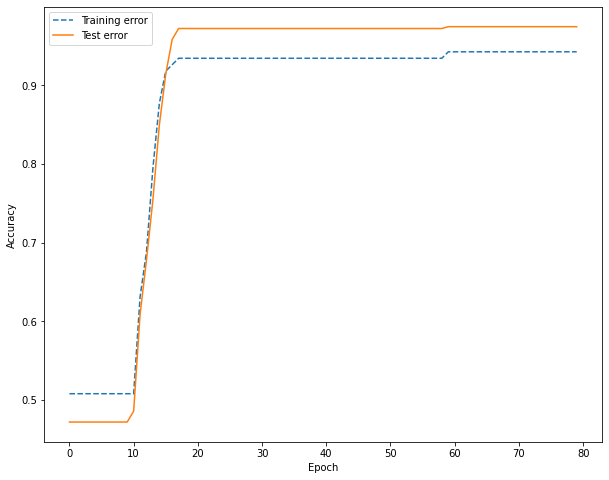

In [ ]:
plot_learning_curves(train_scores_M3, test_scores_M3, 80, 'Accuracy')

In [ ]:
y_predicted_M3 = net_enc3.predict(X_testFit3)
print(f"Accuracy on MONK3: {net_enc3.score(X_testFit3, y_testFit3)}")
print(f"MEE on MONK3: {(np.linalg.norm(y_predicted_M3-y_testFit3))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK3: 0.9745370370370371
MEE on MONK3: 3.316624879837036


In [ ]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit3, y_predicted_M3))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       204
         1.0       1.00      0.95      0.98       228

    accuracy                           0.97       432
   macro avg       0.97      0.98      0.97       432
weighted avg       0.98      0.97      0.97       432



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>